# Analyze NHL Stats 


## 1. Setup and inspection

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 Load the dataset

After running the first cell to load all necessary libraries, we need to load our dataset. Using pandas, load the dataset `2009to2019-teamsData.csv` and save it as `nhl`. Inspect the first few rows.

<details>
    <summary style="display:list-item;"><b>Toggle for an overview of the variables in our dataset.</b></summary>

* `link`: team's api name
* `abbreviation`: team name abbreviation
* `franchiseId`: team's franchise ID
* `season`: season for which results are given, e.g. 2000-01 season will show as 20002001.
* `clinchIndicator`: indicates whether team clinched playoff spot
* `wins`: 
* `losses`: 
* `ot`:
* `pts`: 
* `ptPctg`:
* `goalsPerGame`:
* `goalsAgainstPerGame`:
* `evGGARatio`:
* `powerPlayPercentage`: 
* `powerPlayGoals`: 
* `powerPlayGoalsAgainst`: 
* `powerPlayOpportunities`: 
* `penaltyKillPercentage`: 
* `shotsPerGame`: 
* `shotsAllowed`: 
* `winScoreFirst`: 
* `winOppScoreFirst`: 
* `winLeadFirstPer`: 
* `winLeadSecondPer`: 
* `winOutshootOpp`: 
* `winOutshotByOpp`: 
* `faceOffsTaken`: 
* `faceOffsWon`: 
* `faceOffsLost`: 
* `faceOffWinPercentage`: 
* `shootingPctg`: 
* `savePctg`: 
</details>

In [21]:
# load dataset
nhlraw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2009to2019-teamsData.csv")

# inspect first few rows
d = {"clinchIndicator":'int32', "gamesPlayed":'int32', "wins":'int32', "losses":'int32', "ot":'int32', "pts":'int32'}
nhl = nhlraw.astype(dtype=d, copy=False)
nhl = nhl.drop(['link', 'firstYearOfPlay', 'franchiseId', 'active', 'gamesPlayed', 'wins', 'losses', 'ot', 'season', 'abbreviation', 'pts', 'ptPctg'], axis=1)
#nhl = nhl.drop(['winOppScoreFirst', 'winOutshotByOpp', 'winOppScoreFirst', 'faceOffsWon', 'faceOffsLost'], axis=1)
nhl.head()
#nhl.columns
#nhlraw[nhlraw['season'] == 20182019].dtypes
#nhlraw['season'].unique()
#nhlraw.columns

,clinchIndicator,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,...,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg
0,1,2.634,2.268,1.0896,18.7,51.0,41.0,273.0,82.8,29.9878,...,0.813,0.943,0.542,0.700,4244.0,2098.0,2146.0,49.4,8.8,0.916
1,0,2.610,3.146,0.8333,16.0,49.0,71.0,306.0,76.3,30.4024,...,0.600,0.794,0.405,0.462,4687.0,2261.0,2426.0,48.2,8.6,0.901
2,0,2.671,2.610,1.0643,18.3,55.0,50.0,301.0,84.3,29.5732,...,0.692,0.842,0.447,0.463,4545.0,2235.0,2310.0,49.2,9.0,0.913
3,1,2.829,2.707,0.9724,21.4,68.0,57.0,317.0,83.0,31.5732,...,0.786,0.882,0.449,0.556,4823.0,2415.0,2408.0,50.1,9.0,0.905
4,1,3.037,2.866,1.0745,17.2,56.0,52.0,326.0,84.1,32.7805,...,0.769,0.848,0.571,0.517,4754.0,2342.0,2412.0,49.3,9.3,0.900


### 1.2. Summarize outcomes

Next, we want to examine our outcome variable to find out how wins and losses are recorded. Check the counts of each value of the `result` variable.

In [166]:
# check result value counts
nhl.value_counts("clinchIndicator")


clinchIndicator
1    160
0    142
dtype: int64

### 1.3. Visualize the stats

Now let's take a moment to explore trends in the stats we will be using to predict wins. The variable `stat` has been set to `ptPctg` by default. 

Use `sns.boxplot()` to create a box plot of `stat` by wins and losses. Set the `x`, `y`, and `data` parameters inside the function and save the plot as `stat_plot`.

We've included code for plot labels and to view a list of the names of the stats in the dataset. Try changing the value of the `stat` variable to any one of the stat names and run the cell again to see a plot of how losing teams' stats compare to winning teams' stats.

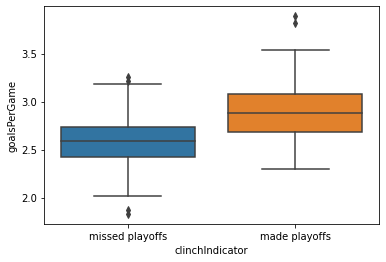

Index(['goalsPerGame', 'goalsAgainstPerGame', 'evGGARatio',
       'powerPlayPercentage', 'powerPlayGoals', 'powerPlayGoalsAgainst',
       'powerPlayOpportunities', 'penaltyKillPercentage', 'shotsPerGame',
       'shotsAllowed', 'winScoreFirst', 'winOppScoreFirst', 'winLeadFirstPer',
       'winLeadSecondPer', 'winOutshootOpp', 'winOutshotByOpp',
       'faceOffsTaken', 'faceOffsWon', 'faceOffsLost', 'faceOffWinPercentage',
       'shootingPctg', 'savePctg'],
      dtype='object')


In [167]:
# change stat to view plot
stat = 'goalsPerGame'

# box plot of stat
stat_plot = sns.boxplot(x='clinchIndicator', y=stat, data=nhl)

# plot labels
stat_plot.set_xticklabels(['missed playoffs','made playoffs'])
plt.show()

# list feature names
print(nhl.columns[1:])

## 2. Data Preparation

### 2.1. Standardize features

Before running our regression, we need to prepare our data by standardizing all the game stats. The provided code saves the game stats to a variable named `features` and saves the necessary scaling function as `scaler`.

Use the function `scaler.fit()` to fit `features` to the the scaling function. Then use `scaler.transform()` to standardize the game stats. Save this output as `X`.

In [168]:
# select feature variables to be scaled
features = nhl.iloc[:,1:]
scaler = StandardScaler()

# fit the transformer to the features
scaler.fit(features)

# transform and save as X
X = scaler.transform(features)

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

How did the functions from the `sklearn` library standardize our stats? The functions transformed our stats by subtracting the mean and dividing by the standard deviation. The result is that each stat now has a mean of 0 and a standard deviation of 1. Some benefits of standardizing include:
* All the stats will be put in the same units, so we can compare them to one another and see which were most important to the model later in the process.
* Many tuning techniques require standardization. We can use those techniques to improve prediction model accuracy.

</details>

### 2.2. Save game outcomes

Let's also separate our playoff clinching outcome variable for easier reference. Save the game outcomes as a variable called `y`.

In [169]:
# save result variable as y
y = nhl["clinchIndicator"]

### 2.3. Split into training and testing data

We need to randomly split the data into two groups:
* **training data:** we'll use this data to train our model to recognize winning games from patterns in the game stats.
* **testing data:** we'll use this data to check our model's accuracy.

Use the `train_test_split()` function imported from the `sklearn` library to split the data. This function will split up our features and result labels into training data and testing data, with `test_size` corresponding to the proportion of data reserved for testing. Set `test_size` to 0.5 and `random_state` to 42.

In [170]:
# create train-test split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

We saved our training data as `X_train` (game stats) and `y_train` (game outcome) and our testing data as `X_test` (game stats) and `y_test` (game outcome).
    
One benefit of using the `train_test_split()` is that rows are selected at random throughout the dataset. This is important in-context because, had we not selected at random, we might bias our model to specific teams or to the early games of the season.
    
In this case, we are using a test size of 0.5, meaning half of our data will be used to train the model and half will be used to test the model's accuracy. We give `random_state` a number just to guarantee that anyone who runs this notebook will get the same random split that we did.

</details>

## 3. Analysis

### 3.1. Run the model

In this step, we'll train our model to use the patterns of the offensive and defensive stats to predict the probability of a winning game.

Create a `LogisticRegression()` classifier and save it to the variable `lrc`. Then call the `.fit()` function using the training data `X_train` and `y_train`.

In [171]:
# create the classifier
lrc = LogisticRegression(C=0.5)

# fit classifier to the training data
lrc.fit(X_train, y_train)

LogisticRegression(C=0.5)

### 3.2. Check model accuracy

With our classifier fitted (trained) to the training data, we can use the trained classifier to make predictions on the test data. Pass the test features `X_test` as a parameter  of `lrc.predict()` and save the resulting predictions as `y_pred`.

Now we can check the percentage of outcomes that our model predicted correctly. Use the `accuracy_score()` function imported from the `sklearn` library to compare our predicted test values `y_pred` to the true values `y_test`.

In [172]:
# predict with the classifier using the .predict() function
y_pred = lrc.predict(X_test)

# view the model accuracy with the accuracy_score() function
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9072847682119205

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

We can see from the model performance that we can predict wins and losses with good accuracy. Our model correctly predicted the playoff clinching outcome for 93.4% of the playoff clinchers in the test set. The next steps might be to try to tune the model to optimize predictive performance.

</details>

### 3.2. Optimize by tuning hyperparameters

We can improve our model performance by closely studying how different paremeters affect performance. Let's consider two hyperparameters for the `LogisticRegression` classifer: `penalty` and `C`.

* `penalty` imposes a regularization penalty on the model for having too many variables. Our options generally are `l1` and `l2` regularization.
* `C` is the inverse of regularization strength. It is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting.

The following code runs a logistic regression on our same data and gets an accuracy score for each combination of `penalty` and `C`. Run the code to see how model accuracy changes when we use different values of these hyperparameters. If you'd like, try changing the values of `C` in the list.

In [173]:
# create a list of penalties
penalties = ['l1', 'l2']
# create a list of values for C
C = [0.01, 0.1, 1.0, 10.0, 1000.0]

acc_list = []
pen_list = []
c_list   = []

for penalty in penalties:
    for c in C:

        # instantiate the classifier
        lrc_tuned = LogisticRegression(penalty=penalty, C=c, solver='liblinear')

        # fit the classifier to the training data
        lrc_tuned.fit(X_train, y_train)
        
        # predict with the classifier using the .predict() function
        y_pred = lrc_tuned.predict(X_test)

        # view the model accuracy with the accuracy_score() function
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_rd = round(accuracy*100,1)

        acc_list.append(accuracy_rd)
        pen_list.append(penalty)
        c_list.append(c)

# store opt_penalty and opt_c_val for maximum accuracy
opt_penalty = pen_list[acc_list.index(max(acc_list))]
opt_c_val   = c_list[acc_list.index(max(acc_list))]

# print accuracy for each combination of penalty and C
print(f'Accuracy: {max(acc_list)}% | penalty = {opt_penalty}, C = {opt_c_val}')

Accuracy: 92.7% | penalty = l1, C = 1.0


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

A lot of these accuracy scores are very similar (or identical) to our original accuracy score. This is due in part to the fact that `sklearn` automatically uses regularization with `penalty = l2` and `C = 1.0`. While this is not always the case, we gain a small benefit by changing the hyperparameters to `penalty = l1` and `C = 0.1`. This brings us from 82.8% to 84.6% accuracy.

</details>

### 3.4. Optimize by changing test size

In the cell above, we see that sweeping our parameters did not yield much improvement in prediction accuracy. Let's try another method of parameter tuning: changing the test size of the train-test split. A list of test sizes between 0 and 1 has been coded for you. Similar to the last task, at each test size the code performs a train-test split, fits the model, and computes an accuracy score.

Run the code to see how test size affects accuracy. If you'd like, try changing the list of test sizes to get better accuracy.

In [174]:
# optimal penalty and C
penalty = 'l1'
C = 1.0

# create a list of test_sizes
test_sizes = [val/100 for val in range(20,36)]
acc_list = []
size_list = []

for test_size in test_sizes:

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # instantiate the classifier
    lrc_tts = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

    # fit the classifier to the training data
    lrc_tts.fit(X_train, y_train)

    # predict with the classifier using the .predict() function
    y_pred = lrc_tts.predict(X_test)

    # view the model accuracy with the accuracy_score() function
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_rd = round(accuracy*100,1)
    
    size_list.append(test_size)
    acc_list.append(accuracy_rd)

# store test_size for maximum accuracy
opt_test_size = size_list[acc_list.index(max(acc_list))]

# print accuracy for each combination of penalty and test size
print(f'Max Accuracy: {max(acc_list)}% | test size = {opt_test_size}')


Max Accuracy: 94.3% | test size = 0.29


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

As we can see from the output, we were able to improve accuracy slightly with a test size of `0.25`. In this step, we improved from 84.6% correct predictions to 88.8% correct predictions. Nice!

</details>

### 3.5. Save the optimized model

Now that we know which parameters optimize our model, let's run and save the final model with our choices for `test_size`, `penalty`, and `C`. Fill in the code to run and save the final model as `optLr`. Continue setting `random_state=42` for the split.

In [175]:
# set the test size and hyperparameters
test_size = opt_test_size
penalty   = opt_penalty
C         = opt_c_val

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# instantiate the classifier
optLr = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

# fit the classifier to the training data
optLr.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

### 3.6. Examine feature importance

Let's find out which stats were most important to our model predicting wins. The absolute values of the model coefficients has been saved for you as `importance`. We'll print and plot these scores to see which stat has the highest score.

Add code to create a bar plot of the feature importances.

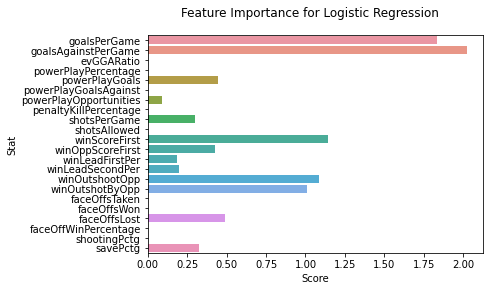

Feature: goalsAgainstPerGame, Score: 2.02
Feature: goalsPerGame, Score: 1.83
Feature: winScoreFirst, Score: 1.14
Feature: winOutshootOpp, Score: 1.09
Feature: winOutshotByOpp, Score: 1.01
Feature: faceOffsLost, Score: 0.49
Feature: powerPlayGoals, Score: 0.44


In [185]:
# get importance
importance = abs(optLr.coef_[0])

# visualize feature importance
sns.barplot(x=importance, y=features.columns)

# add labels and titles
plt.suptitle('Feature Importance for Logistic Regression')
plt.xlabel('Score')
plt.ylabel('Stat')
plt.show()

feature_importance = {}
# summarize feature importance
for i,v in enumerate(importance.round(2)):
  feature_importance[features.columns[i]] = v

sorted_features = sorted(feature_importance.items(), key=lambda x:x[1], reverse=True)
sorted_features_dict = dict(sorted_features)

top_features = 7
for i,v in sorted_features_dict.items():
  print(f'Feature: {i}, Score: {v}')
  top_features -= 1
  if top_features <= 0:
    break


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

It looks like the most important stats in our model are turnovers: 

1.   goalsAgainstPerGame
2.   goalsPerGame
3.   winScoreFirst
4.   winOutshootOpp
5.   winOutshotByOff



</details>

## Conclusion

### 13. Try your model on new data

Congratulations! You've conducted a successful case study on NFL data where the outcome of a game can be predicted using the team's offensive and defensive stats from a given game. 

Want to see how your model holds up for 2022? Change the `team` variable to your favorite team's name in the code cell below. We've provided the helper function `get_new_data()` that will get that team's data for the given year from the site [Pro Football Reference](https://www.pro-football-reference.com/).

We've provided the code for this final step, but we encourage learners who feel confident enough to try the challenge of coding the solution themselves!

In [ ]:
# set team abbreviation (in capitals) and year
team = 'Dallas Cowboys'
year = 2022

# use helper function to pull new data
from helper import get_new_data
new_data = get_new_data(team=team, year=year)

# view head of new data
new_data.head()

,team_name,week,day,date,result,opponent,tm_score,opp_score,1stD_offense,TotYd_offense,PassY_offense,RushY_offense,TO_offense,1stD_defense,TotYd_defense,PassY_defense,RushY_defense,TO_defense
0,Dallas Cowboys,1,Sun,September 11,0,Tampa Bay Buccaneers,3,19,12,244,173,71,1,18,347,195,152,1
1,Dallas Cowboys,2,Sun,September 18,1,Cincinnati Bengals,20,17,19,337,230,107,1,19,254,165,89,0
2,Dallas Cowboys,3,Mon,September 26,1,New York Giants,23,16,23,391,215,176,0,22,336,169,167,1
3,Dallas Cowboys,4,Sun,October 2,1,Washington Commanders,25,10,15,279,217,62,0,17,297,155,142,2
4,Dallas Cowboys,5,Sun,October 9,1,Los Angeles Rams,22,10,10,239,76,163,0,14,323,285,38,3


<details>
    <summary style="display:list-item; font-size:16px;"><i>Need to check the team names? Toggle for code to print a list!</i></summary>

Copy and paste this code into a new code cell to get a list of team names.

```py
list(nfl.team_name.unique())
```

</details>

Before we can run the data in our model and get predictions, we need to standardize the stats using the same `scaler` we used for our original dataset.

In [ ]:
# select just the game stats
new_X = new_data.loc[:,features.columns]

# standardize using original data's scaling
new_X_sc = scaler.transform(new_X)

Now we can use our model to make predictions and get an accuracy score for how well our model predicted wins with the new data.

In [ ]:
# get new predictions
new_preds = optLr.predict(new_X_sc)

# get actual results and set type to float
new_results = new_data['result'].astype(float)

# get accuracy score for new data
acc_score = accuracy_score(new_results, new_preds)

Let's put all this information together in a table and print out our accuracy score.

In [ ]:
# select only game data
col_names = ['day', 'date', 'result', 'opponent', 'tm_score', 'opp_score']
game_data = new_data.loc[:,col_names]
# create comparison table
comp_table = game_data.assign(predicted = new_preds,
                              actual = new_results.astype(int))

In [ ]:
# print title and table
print(f'Predicted Wins vs Actual Wins for {team} in {year}')
comp_table

Predicted Wins vs Actual Wins for Dallas Cowboys in 2022


,day,date,result,opponent,tm_score,opp_score,predicted,actual
0,Sun,September 11,0,Tampa Bay Buccaneers,3,19,0,0
1,Sun,September 18,1,Cincinnati Bengals,20,17,1,1
2,Mon,September 26,1,New York Giants,23,16,1,1
3,Sun,October 2,1,Washington Commanders,25,10,1,1
4,Sun,October 9,1,Los Angeles Rams,22,10,1,1
5,Sun,October 16,0,Philadelphia Eagles,17,26,0,0


In [ ]:
# print accuracy
print(f'\nCurrent Accuracy Score: ' + str(round(acc_score*100,1)) + '%')


Current Accuracy Score: 100.0%


Our table gives us some context on the game, the opponent, and our prediction. Feel free to go back and change the team name or year (you can look at past years too!).